# Team 23

Rajshree Jain : rjain27@ncsu.edu </br>
Sai Shruthi Madhuri Kara : skara2@ncsu.edu</br>
Sruthi Talluri : stallur2@ncsu.edu

# Loading and importing Libraries

In [ ]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob
import keras
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
from collections import Counter 
from keras.preprocessing import image
from tqdm import tqdm
from PIL import ImageFile 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras import Model,Sequential
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from skimage import exposure
from imblearn.under_sampling import NearMiss
from keras.applications import VGG16
from keras.models import Model
from keras.layers import MaxPooling2D, InputLayer, BatchNormalization, Input
from keras.models import Sequential
from keras import optimizers
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.layers import GlobalMaxPooling2D
from keras.utils import to_categorical
import keras.metrics as km
from keras import backend as K
from keras.optimizers import SGD, Adam, RMSprop
import tensorflow as tf

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data from Drive

The data is located in the following location. Please change the path to execute from any other file location

In [ ]:
# Reading Directory Data 
in_annotation_dir = "/content/drive/My Drive/NN Project 1 /ECE542_fa20_Project_LeafWilting/TrainingData/Annotations.csv"
in_train_dir = "/content/drive/My Drive/NN Project 1 /ECE542_fa20_Project_LeafWilting/TrainingData"
in_test_dir = "/content/drive/My Drive/NN Project 1 /ECE542_fa20_Project_LeafWilting/TestData"

# Read the Annotations File 
annotations_df = pd.read_csv(in_annotation_dir)

In [ ]:
# Print of first 5 items in the annotations file 
annotations_df.head(5)

,file_name,annotation
0,000006.jpg,0
1,000016.jpg,0
2,000032.jpg,0
3,000097.jpg,4
4,000104.jpg,0


In [ ]:
train_annotation = annotations_df['annotation'] 
print("The number of images with annotations are ", str(len(train_annotation)))

The number of images with annotations are  1275


In [ ]:
data_train_path = [os.path.join(in_train_dir, f) for f in annotations_df['file_name']]

In [ ]:
data_test_paths = [os.path.join(pth, f) for pth, dirs, files in os.walk(in_test_dir) for f in files]

In [ ]:
print ("The length of training data is", len(data_train_path))

The length of training data is 1275


In [ ]:
print ("The length of test data is", len(data_test_paths))

The length of test data is 200


In [ ]:
data_test_file_names = [f for pth, dirs, files in os.walk(in_test_dir) for f in files]

# Exploratory Data Analysis

Color Intensity Graph of Image


In [ ]:
def intensity_dist(path):
    #reading the image from its path
    img = cv2.imread(path)
    color = ('b','g','r')
    #calculating the number of pixels of each color
    for i, col in enumerate(color):
        histr = cv2.calcHist([img], [i], None, [256], [0,256])
        plt.plot(histr, color=col)
    print("Histogram for color Internsity of the image below:")
    
    #showing the histogram
    plt.xlabel("value of the pixel for the given channel")
    plt.ylabel("Number of pixels")
    plt.show()
    
    #showing the image
    plt.imshow(img)
    plt.show()
    height, width, channels = img.shape
    print("Size of the image - (%d , %d)"%(height,width)) 
    print("-"*100)
    
intensity_dist(data_train_path[56])

# Class Distribution of Images

The number of images of each class are printed and shown in the graph to help us understand the distribution and perform any class balancing methods

488
329
130
131
197


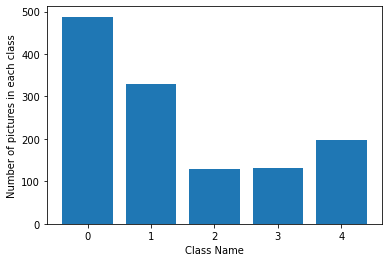

In [ ]:
d = Counter(train_annotation)
x=np.arange(5)
class_count = []
for i in range(0, 5):
  class_count.append(d[i])
  print(i+"-"+d[i])
fig, ax = plt.subplots()
plt.bar(x, class_count)
plt.xticks(x, (0, 1, 2, 3, 4))
plt.xlabel("Class Name")
plt.ylabel("Number of pictures in each class")
plt.show()

# Convert Image to Tensor 

The images are converted into tensor, for easier inputting into the models like VGG19

In [ ]:
#converting image to tensor
def path_to_tensor(img_path):
    # loads RGB image
    img = image.load_img(img_path, target_size=(80,80))
    x = image.img_to_array(img)
    #convert 3D tensor to 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True 
train_tensors = paths_to_tensor(data_train_path).astype('float32')/255
test_tensors = paths_to_tensor(data_test_paths).astype('float32')/255
print(np.shape(train_tensors))
print(np.shape(test_tensors))

  9%|▉         | 120/1275 [00:31<05:00,  3.84it/s]

# Random Forest 

We perform a traditional machine learning algorithm to help us understand how to work with images.

In [ ]:
# Reshapping of the input train tensors into 1 dimension
X_train = train_tensors.reshape(train_tensors.shape[0], -1)
Y_train = annotations_df['annotation']

In [ ]:
# Random Forest Classifier with validation split of 0.3
clf = RandomForestClassifier()
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Accuracy and Confusion Matrix For Random Forest 

In [ ]:
# Predictiond for validation data and printing of accuracy, precision etc. 
preds = clf.predict(X_val.reshape(X_val.shape[0], -1))
print("Accuracy:", accuracy_score(Y_val,preds))
print("Confusion Matrix",confusion_matrix(Y_val, preds))
print("Precision, Recall and Fscore are:", precision_recall_fscore_support(Y_val, preds, average='macro'))
print("Precision Recall for all class", classification_report(Y_val,preds))

Accuracy: 0.6997389033942559
Confusion Matrix [[131   8   0   0   0]
 [ 42  53   0   0   0]
 [ 26  11  10   2   0]
 [  9   4   1  24   1]
 [  6   2   0   3  50]]
Precision, Recall and Fscore are: (0.8017411970095332, 0.6278958318385581, 0.6573998447730958, None)


NameError: ignored

In [ ]:
# Generation predictions for Test Data and saving into an excel
X_test = test_tensors.reshape(test_tensors.shape[0], -1)
pred_unknown = clf.predict(X_test)
prediction_rf_df = pd.DataFrame(pred_unknown)
prediction_rf_df.columns = ['annotation']
prediction_rf_df['file_name'] = data_test_file_names
prediction_rf_df.to_csv('predictionRF.csv')

# SMOTE - Oversampling

Performing class balancing method to generate equal images of each class using oversampling method

In [ ]:
smote=SMOTE()
X_train,Y_train=smote.fit_resample(train_tensors.reshape(train_tensors.shape[0], -1),annotations_df['annotation'])

NameError: ignored

In [ ]:
# Printing the length of the train data 
print(len(X_train))
print(len(Y_train))

2440
2440


# Class Distribution after Oversampling

Checking class distribution of images after SMOTE

In [ ]:
d = Counter(Y_train)
x=np.arange(5)
class_count1 = []
for i in range(0, 5):
  class_count1.append(d[i])
fig, ax = plt.subplots()
plt.bar(x, class_count1)
plt.xticks(x, (0, 1, 2, 3, 4))
plt.xlabel("Class Name")
plt.ylabel("Number of pictures in each class")
plt.show()

NameError: ignored

# Random Forest After Sampling 

We perform Random Forest classification after SMOTE, to see how the predictions have improved.

In [ ]:
clf = RandomForestClassifier()
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Accuracy and Confusion Matrix For Random Forest after Oversampling

In [ ]:
# Predictiond for validation data and printing of accuracy, precision etc. 
preds = clf.predict(X_val.reshape(X_val.shape[0], -1))
print("Accuracy:", accuracy_score(Y_val,preds))
print("Confusion Matrix",confusion_matrix(Y_val, preds))
print("Precision, Recall and Fscore are:", precision_recall_fscore_support(Y_val, preds, average='macro'))
print("Precision Recall for all class", classification_report(Y_val,preds))


Accuracy: 0.930327868852459
Confusion Matrix [[129  15   1   3   0]
 [ 26 129   0   0   0]
 [  1   2 150   1   0]
 [  0   0   1 132   0]
 [  0   0   0   1 141]]
Precision, Recall and Fscore are: (0.9321660951313776, 0.9326689219300233, 0.9320926866810204, None)
Precision Recall for all class               precision    recall  f1-score   support

           0       0.83      0.87      0.85       148
           1       0.88      0.83      0.86       155
           2       0.99      0.97      0.98       154
           3       0.96      0.99      0.98       133
           4       1.00      0.99      1.00       142

    accuracy                           0.93       732
   macro avg       0.93      0.93      0.93       732
weighted avg       0.93      0.93      0.93       732



In [ ]:
# Generation predictions for Test Data and saving into an excel
X_test = test_tensors.reshape(test_tensors.shape[0], -1)
pred_unknown = clf.predict(X_test)
prediction_rf_df = pd.DataFrame(pred_unknown)
prediction_rf_df.columns = ['annotation']
prediction_rf_df['file_name'] = annotations_df['file_name'] 
prediction_rf_df.to_csv('predictionRF_Sampling.csv')

Reshapping of X into 3 dimensional data

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 80, 80, 3)

In [ ]:
# Printing the shape
X_train.shape

(2440, 80, 80, 3)

In [ ]:
# Printing the shape
Y_train.shape

(2440,)

# Graph Plotting for Validation Accuracy and Loss

A function to help plot the validation Accuracy and Validation Loss

In [ ]:
import sys, time

def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

# Resnet 152

We have performed the Resnet 152 architecture for the data

In [ ]:
# Loading the Image Data for training images
def load_data():
  X = []
  y = []
  for i, row in tqdm(annotations_df.iterrows()):
    filename = row["file_name"] 
    # Using the annotations csv for Y_train
    label = row["annotation"]
    file = open(data_train_path[i],'rb')
    im = cv2.imread(data_train_path[i])
    X.append(im)
    y.append(label)
  X = np.array(X)
  y = np.array(y)
  print(X.shape)
  
  return X,y
# Function Calling 
X,y = load_data()

1275it [04:43,  4.50it/s]


(1275, 480, 640, 3)


# Near-Miss Undersampling

We tried using Resnet 152 on Oversampled data, but it led to Memory oytage hence we tried using the Undersampling class balancing method

In [ ]:
# NearMiss Undersampling
nm=NearMiss()
X_train,Y_train=nm.fit_resample(X.reshape(X.shape[0], -1),y)
X_train = X_train.reshape(X_train.shape[0], 480, 640, 3)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
# Printing length of data after Undersampling 
print(len(X_train))
print(len(Y_train))

650
650


In [ ]:
# Test and Train split 
trainX, valX, trainY, valY = train_test_split(X_train,Y_train,test_size=0.2, stratify=Y_train)

In [ ]:
# Defining Model to fit the 5 class distribution of our data 

def create_model(input_shape):
  model = Sequential()
  model.add(GlobalAveragePooling2D(input_shape=input_shape))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(5, activation='softmax'))
  return model

In [ ]:
# Resnet model definition from keras
model_resnet = keras.applications.resnet.ResNet152(include_top=False, weights='imagenet',input_tensor=None, input_shape=None, pooling=None)

234700800/234698864 [==============================] - 2s 0us/step


In [ ]:
output = model_resnet.output
resnet_optimized_model = Model(model_resnet.input,output)

In [ ]:
# Feature extraction for Restnet Model 
resnet_trainFeatures=resnet_optimized_model.predict(trainX)
resnet_valFeatures=resnet_optimized_model.predict(valX)
resnet_trainFeatures.shape

(520, 15, 20, 2048)

In [ ]:
# Defining early etopping to prevent overfitting of the data (monitor Validation Loss )
model_name = "resnet"
checkpointer = ModelCheckpoint(model_name + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1,save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=48, verbose=1, mode='auto')
tensorboard_cnn = TensorBoard(log_dir='./Graph_CNN', histogram_freq=0,write_graph=True, write_images=True)
calls = [early_stopping]


In [ ]:
# Final calling create model 
res_model = create_model(input_shape = (15, 20, 2048))
res_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
res_history = res_model.fit(resnet_trainFeatures,trainY,validation_data=(resnet_valFeatures,valY), epochs=150, callbacks=calls, verbose=True, batch_size=256, shuffle=True)

Epoch 1/150
3/3 [==============================] - 1s 251ms/step - loss: 2.5711 - accuracy: 0.2942 - val_loss: 2.6232 - val_accuracy: 0.2846
Epoch 2/150
3/3 [==============================] - 1s 195ms/step - loss: 2.1604 - accuracy: 0.4442 - val_loss: 1.1339 - val_accuracy: 0.5308
Epoch 3/150
3/3 [==============================] - 1s 203ms/step - loss: 1.2567 - accuracy: 0.5135 - val_loss: 0.8552 - val_accuracy: 0.6154
Epoch 4/150
3/3 [==============================] - 1s 199ms/step - loss: 0.9811 - accuracy: 0.5885 - val_loss: 0.9422 - val_accuracy: 0.6000
Epoch 5/150
3/3 [==============================] - 1s 200ms/step - loss: 1.0543 - accuracy: 0.5981 - val_loss: 0.7008 - val_accuracy: 0.7308
Epoch 6/150
3/3 [==============================] - 1s 202ms/step - loss: 0.8325 - accuracy: 0.6712 - val_loss: 0.6799 - val_accuracy: 0.6923
Epoch 7/150
3/3 [==============================] - 1s 198ms/step - loss: 0.7693 - accuracy: 0.6962 - val_loss: 0.6253 - val_accuracy: 0.7385
Epoch 8/150
3

The results in the accuracy though high, cannot be considered final due to very less amount of train data of only 650 images. The results os the F1 score of this prediction performed poorly in the test 

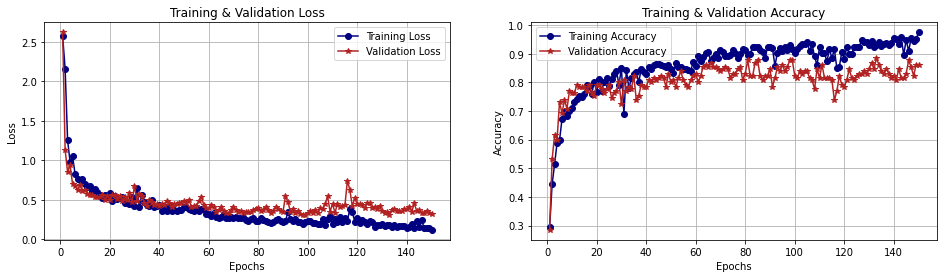

In [ ]:
# Using the graph Plotting function 
show_plots(res_history.history)

In [ ]:
# Loading of the Test Data Images 
def load_test_data():
  X_test = []
  for i in range(200):
    file = open(data_test_paths[i],'rb')
    im = cv2.imread(data_test_paths[i])
    X_test.append(im)
  X_test = np.array(X_test)
  print(X_test.shape)
  
  return X_test

X_test = load_test_data()

(200, 480, 640, 3)


In [ ]:
print(len(X_test))

200


In [ ]:
# Generating a Prediction excel for Resnet Model 
resnet_testFeatures=resnet_optimized_model.predict(X_test)
resnet_preds = res_model.predict(resnet_testFeatures)
prediction_res_df.columns = ['annotation']
prediction_res_df['file_name'] = data_test_file_names
prediction_res_df.to_csv('predictionResNet.csv')

# VGG 16 

We then performed VGG16 architecture on the data 

In [ ]:
# Defining VGG16 model  
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
x = base_model.output

# Adding layers to output 5 classes for our data 
x = Flatten(name="flatten")(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(5, activation="softmax")(x)


vgg16model = Model(inputs=base_model.input, outputs=x)
for layer in base_model.layers:
	layer.trainable = False

vgg16model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112

In [ ]:
# Compling Model 
vgg16model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.00001),
metrics=["accuracy"])

In [ ]:
# Test and Train split 
trainX, valX, trainY, valY = train_test_split(X_train,Y_train,test_size=0.2, stratify=Y_train)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.000001)

filepath="weights.bestVGG.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
filepath="weights.lastVGG_auto.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]
H = vgg16model.fit(
	train_datagen.flow(trainX, trainY, batch_size= 32),
	validation_data=test_datagen.flow(valX, valY, batch_size= 32),
	epochs=20,
  steps_per_epoch=200, 
  callbacks = callbacks_list)

In [ ]:
# Generating Predictions for VGG 16 model on test data and excel creation
predsVgg16=vgg16model.predict(X_test)
predsVgg16_value = np.argmax(predsVgg16,axis = 1)
prediction_vgg16_df = pd.DataFrame(predsVgg16_value)
prediction_vgg16_df.columns = ['annotation']
prediction_vgg16_df['file_name'] = data_test_file_names
prediction_vgg16_df.to_csv('predictionVGG16.csv')

# VGG 19

We then performed VGG19 architecture using our Train and Tets tensors

In [ ]:
#Extracting the weights of VGG19 model pretrained on Imagenet
#defing the Input shape
input_tensor = Input(shape=(80, 80, 3))
#extracting the weights wof VGG19, without top layers
#and MaxPooling as pooling layer
base_model = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling=max)
#removing the last layer
output = base_model.get_layer(index = -1).output
#defining the model
VGG19_model2 = Model(base_model.input, output)
base_model.summary()
len(base_model.layers)

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

22

# Feature Extraction 

In [ ]:
# Feature extraction for train tensors
VGG19_features = [VGG19_model2.predict(np.expand_dims(train_tensor, axis=0)) for train_tensor in X_train]
# Feature extraction for test tensors
VGG19_features_test = [VGG19_model2.predict(np.expand_dims(test_tensor, axis=0)) for test_tensor in test_tensors]

print ("Shape of VGG_19_features: {0}".format(np.shape(VGG19_features)))
print ("Shape of VGG_19_features_test: {0}".format(np.shape(VGG19_features_test)))


Shape of VGG_19_features: (2440, 1, 2, 2, 512)
Shape of VGG_19_features_test: (200, 1, 2, 2, 512)


In [ ]:
#squeezing the train features
squeezed_VGG19_train = np.squeeze(VGG19_features, axis=1)
#squeezing the test features
squeezed_VGG19_test = np.squeeze(VGG19_features_test, axis=1)

print ("Shape of squeezed_VGG19_train: {0}".format(np.shape(squeezed_VGG19_train)))
print ("Shape of squeezed_VGG_19_test: {0}".format(np.shape(squeezed_VGG19_test)))

Shape of squeezed_VGG19_train: (2440, 2, 2, 512)
Shape of squeezed_VGG_19_test: (200, 2, 2, 512)


#  VGG 19 - With Feature Extraction

In [ ]:
leaf_model_vgg = Sequential()
#adding a GlobalMaxPooling2D layer with with input shape same as the shape of Squeezed_VGG19_train.
leaf_model_vgg.add(GlobalMaxPooling2D(input_shape=squeezed_VGG19_train.shape[1:]))
#adding a fully connected dense layer with relu activation function
leaf_model_vgg.add(Dense(1024, activation='relu'))
#adding a dense layer with softmax activation function.
#no of nodes are same as the number of classes of fish.
leaf_model_vgg.add(Dense(5, activation = 'softmax'))
leaf_model_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_max_pooling2d_3 (Glob (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 5125      
Total params: 530,437
Trainable params: 530,437
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_targets = to_categorical(Y_train)

In [ ]:
leaf_model_vgg.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', Precision(), Recall()])

#checkpointer for saving only best weights
checkpointer_VGG = ModelCheckpoint(filepath='leaf_model_vgg_point.hdf5', verbose=1, save_best_only=True)

early = EarlyStopping(monitor='val_loss',min_delta=0.01, patience=0, verbose=1)

callbacks_list = [checkpointer_VGG,early] #early

optimized_model_VGG = leaf_model_vgg.fit(squeezed_VGG19_train,train_targets,validation_split=0.3,batch_size=10, epochs=10,callbacks=callbacks_list,verbose=1)


Epoch 1/10
161/171 [===========================>..] - ETA: 0s - loss: 0.5217 - accuracy: 0.8000 - precision_14: 0.8320 - recall_12: 0.7752
Epoch 00001: val_loss improved from inf to 1.94506, saving model to leaf_model_vgg_point.hdf5
171/171 [==============================] - 1s 7ms/step - loss: 0.5190 - accuracy: 0.7992 - precision_14: 0.8305 - recall_12: 0.7746 - val_loss: 1.9451 - val_accuracy: 0.3634 - val_precision_14: 0.3865 - val_recall_12: 0.3046
Epoch 2/10
164/171 [===========================>..] - ETA: 0s - loss: 0.4850 - accuracy: 0.7970 - precision_14: 0.8216 - recall_12: 0.7665
Epoch 00002: val_loss improved from 1.94506 to 0.63725, saving model to leaf_model_vgg_point.hdf5
171/171 [==============================] - 1s 5ms/step - loss: 0.4855 - accuracy: 0.7957 - precision_14: 0.8216 - recall_12: 0.7658 - val_loss: 0.6373 - val_accuracy: 0.7746 - val_precision_14: 0.8122 - val_recall_12: 0.7090
Epoch 3/10
162/171 [===========================>..] - ETA: 0s - loss: 0.4634 - a

In [ ]:
# Generating Predictions for test data and excel creation 
vgg_19_preds = leaf_model_vgg.predict(squeezed_VGG19_test)
vgg_19_preds_value = np.argmax(vgg_19_preds,axis = 1)
prediction_df = pd.DataFrame(vgg_19_preds_value)
prediction_df.columns = ['annotation']
prediction_df['file_name'] = data_test_file_names
prediction_df.to_csv('predictionVGG19-Feature.csv')

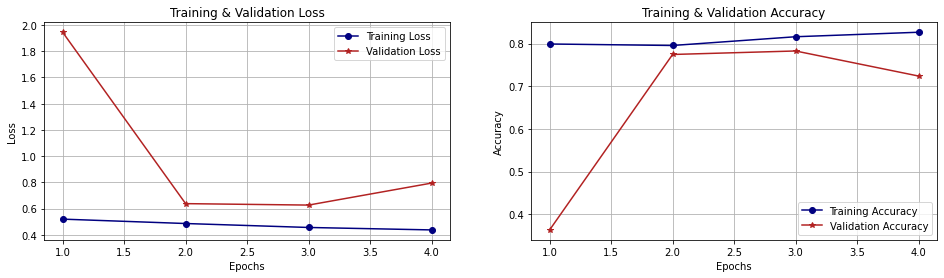

In [ ]:
# Plotting of Model 
show_plots(optimized_model_VGG.history)

# VGG19 - Hyper Parameter Tuning 

We the performed Hyperparamter tuning to VGG 19 as it yielded the best output F1 score for the data

In [ ]:
def create_model(optimizer='adam',dropout_rate=0.0, n_layers = 1):
    leaf_model_vgg = Sequential()
    #adding a GlobalMaxPooling2D layer with with input shape same as the shape of Squeezed_VGG19_train.
    leaf_model_vgg.add(GlobalMaxPooling2D(input_shape=squeezed_VGG19_train.shape[1:]))
    nodes = 1024
    for i in range(1, n_layers+1):
    #adding a fully connected dense layer with relu activation function
      leaf_model_vgg.add(Dense(nodes, activation='relu'))
      leaf_model_vgg.add(Dropout(dropout_rate))
      nodes=nodes/2
    #adding a dense layer with softmax activation function.
    #no of nodes are same as the number of classes of fish.
    leaf_model_vgg.add(Dense(5, activation = 'softmax'))
    leaf_model_vgg.add(Dropout(dropout_rate))

    leaf_model_vgg.summary()
    leaf_model_vgg.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',f1_m,precision_m, recall_m])
    return leaf_model_vgg
# fix random seed for reproducibility


In [ ]:
# Defing the function create recall, precision and f1 metrics for VGG19 model 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Hyperparamter tuning with out learning is performed initially to determine the Optimizer and later Learning rate Hyperparameter tuning is performed for it

In [ ]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.75):   
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.75*100))   
          self.model.stop_training = True

callbacks = myCallback()

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adam']
dropout_rate = [0.1, 0.2, 0.3]
batch_size = [10,20,40]
epochs = [10,15,20]
n_layers = [2,3]
param_grid = dict(optimizer=optimizer,dropout_rate = dropout_rate,batch_size=batch_size,epochs=epochs, n_layers = n_layers)
model = KerasClassifier(build_fn=create_model,batch_size=10,epochs=10, verbose=0)

# Grid Search CV 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
callbacks=[callbacks]
grid_result = grid.fit(squeezed_VGG19_train,train_targets,validation_split=0.3,verbose=1, callbacks=callbacks)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 2565      
_________________________________________________________________
dropout_6 (Dropout)          (None, 5)                

In [ ]:
# Plot function to help determine the comparison of Hyper parameter tuning results 
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

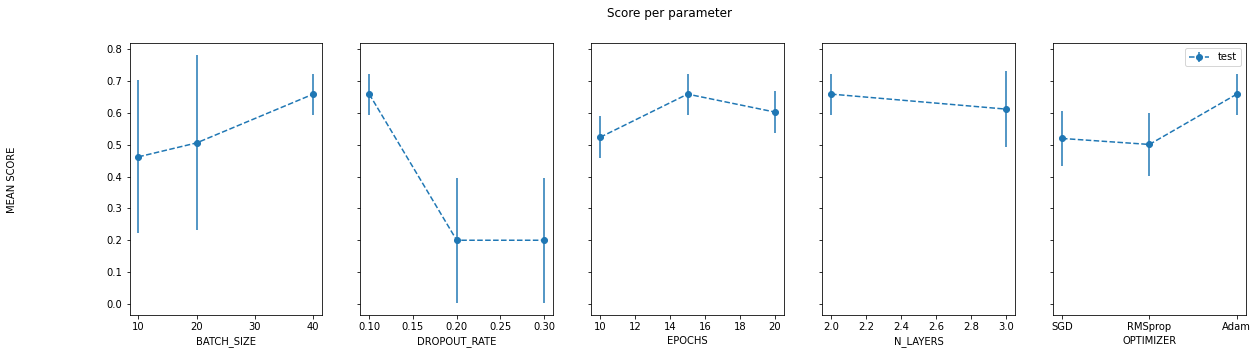

In [ ]:
# Parameter result comparison 
plot_search_results(grid)

Hyperparameter tuning for Learning Rate with the best parameters achieved above. 

In [ ]:
def create_model(dropout_rate=0.1,learn_rate=0.1):
    leaf_model_vgg = Sequential()
    #adding a GlobalMaxPooling2D layer with with input shape same as the shape of Squeezed_VGG19_train.
    leaf_model_vgg.add(GlobalMaxPooling2D(input_shape=squeezed_VGG19_train.shape[1:]))

    nodes = 1024
    n_layers = 2
    for i in range(1, n_layers+1):
    #adding a fully connected dense layer with relu activation function
      leaf_model_vgg.add(Dense(nodes, activation='relu'))
      leaf_model_vgg.add(Dropout(dropout_rate))
      nodes=nodes/2


    leaf_model_vgg.add(Dense(5, activation = 'softmax'))
    leaf_model_vgg.add(Dropout(dropout_rate))

    leaf_model_vgg.summary()
    leaf_model_vgg.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learn_rate), metrics=['accuracy',f1_m,precision_m, recall_m])
    return leaf_model_vgg

In [ ]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.75):   
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.75*100))   
          self.model.stop_training = True

callbacks = myCallback()
learn_rate = [0.1, 0.01, 0.001]
param_grid = dict(learn_rate=learn_rate)
model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=40, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

callbacks=[callbacks]

grid_result = grid.fit(squeezed_VGG19_train,train_targets,validation_split=0.3,verbose=1, callbacks=callbacks)
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_max_pooling2d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 2565      
_________________________________________________________________
dropout_9 (Dropout)          (None, 5)                

In [ ]:
# Printing the grid search results for learning rate 
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

0.199891 (0.195696) with: {'learn_rate': 0.1}
0.199891 (0.195696) with: {'learn_rate': 0.01}
0.557391 (0.036849) with: {'learn_rate': 0.001}


In [ ]:
# Generating predictions for the frid model after hyperparameter tuning 
vgg_19_preds_lr = grid.predict(squeezed_VGG19_test)
print((vgg_19_preds_lr))
prediction_df = pd.DataFrame(vgg_19_preds_lr)
prediction_df.columns = ['annotation']

[1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 2 1 1 1 1 0 0 1 1 1 1 2 1 1 1 1 1 1 1 1 2 3 1 4 1 4 0 1 4 1 4 4 0 4
 4 4 0 1 1 1 0 4 4 0 1 1 4 3 0 4 1 4 0 4 4 4 0 4 4 1 4 4 4 4 4 0 0 4 0 4 1
 0 4 4 4 4 1 1 4 3 1 1 0 1 4 3 1 4 0 1 0 1 1 4 0 1 2 4 4 1 1 0 4 1 1 1 1 4
 1 0 1 4 4 1 0 0 4 4 1 0 4 2 4 4 1 0 0 4 0 1 1 1 1 1 3 1 4 1 1 4 1 1 0 1 1
 0 0 4 1 1 1 4 1 4 1 0 4 0 1 1]


# Creation of the final Prediction Excel 

In [ ]:
prediction_df['file_name'] = data_test_file_names
prediction_df.to_csv('prediction.csv')